# A Demo of Vishn 

This notebook provides simple example uses of Vishn. Beyond understanding how to use the software, hopefully these small toy examples convey the potential of Vishn to configure and run complicated disease simulations. In the following examples we will: create properly formatted network and parameter files used to run a disease simulation, format the configuration file for a simulation/describe what can be configured, and analyze the simulation ouput via visualizations.

#### Contents:
The first example explains in detail each step used to run simulations in Vishn. The following examples follow the same procedure as Example 1, but assume some basic familiarity with the software.

- [Example 1](#1): Path Graph Demonstration
    - [1.1)](#1.1) Creating the graph
    - [1.2)](#1.2) Applying Weights to the Graph
    - [1.3)](#1.3) Creating Parameters for each Host
    - [1.4)](#1.4) The Configuration File
    - [1.5)](#1.5) Running the Simulation and Creating Visualizations
- [Example 2](#2): Barbell Graph Demonstration
    - [2.1)](#2.1) Running the Simulation
    - [2.2)](#2.2) Population Viral Load
- [Example 3](#3): Barabasi-Albert Graph Demonstration
    - [3.1)](#3.1) Running the Simulation
    - [3.2)](#3.2) Population Viral Load


#### Load required packages:

In [53]:
%matplotlib inline
import sys
sys.path.append('../')
import vishn as vn
# Other packages that will be used in this demo, in general not necessary to use Vishn
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

<a id=1></a>
# Example 1: Step-by-Step Demo with Path Graph
<a id=1.1></a>
### 1.1) Creating the graph
In this example, the simulation will run on a path graph containing three nodes. First, create a path graph with 3 nodes using `networkx`. To understand the simulation output in these examples, sometimes it's helpful to plot the network.

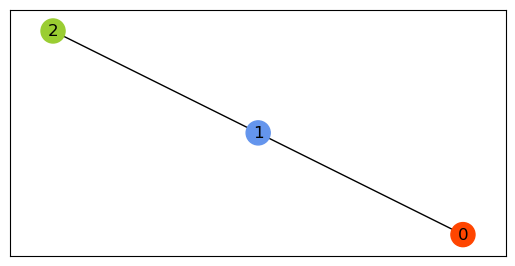

In [54]:
# Creating path graphs
G = nx.path_graph(3)

# Draw the graph
plt.figure(3,figsize=(6.4,3.2)) 
path_colors = ["orangered", "cornflowerblue", "yellowgreen"]
nx.draw_networkx(G, node_color=path_colors, with_labels = True)
plt.show()

<a id=1.2></a>
### 1.2) Applying Weights to the Graph
Vishn requires that all edges of a network have a parameter associated with them called "weight", which can be any float in the range $[0,1]$. In simple terms, the weight parameter is the level of contact between hosts connected by a given edge. A weight close to 0 means the hosts have very little contact and a weight close to 1 means the hosts have very high contact. Mathematically, the weight parameter controls the maximum probability of infection along an edge at a given time step. A weight of 0 is equivalent to the edge being removed from the network.

In this example, we will create two path graphs: one with the weight of all edges set to 0 and the other with all weights being set to 1. If the simulation is running correctly, the virus should not spread at all across the network with all 0 weights, and it should spread quickly across the network with all weights equal to 1.

In [3]:
# G_0 will have all 0 weights, G_1 all 1 weights
G_0 = nx.path_graph(3)
G_1 = nx.path_graph(3)

for edge in G_0.edges():
    G_0[edge[0]][edge[1]]['weight'] = 0
    G_1[edge[0]][edge[1]]['weight'] = 1

# Write network files
nx.write_edgelist(G_0, "Path_0Weight.edgelist")
nx.write_edgelist(G_1, "Path_1Weight.edgelist")    

<a id=1.3></a>
### 1.3) Creating Parameters for Each Host

Vishn embeds a system of differential equations within each host in the simulation. For all of the following examples, the built in TIVE system will be used. The TIVE system has parameters delta, p, c, beta, d, dX, r, alpha, and N. Vishn allows for these parameters to be customized for each host via a pandas dataframe. In the parameter dataframe, a row of index i contains the set of parameters for host i, and the column names are the names of each parameter. For this example and all following ones, each host will have the same set of parameters. 

If you want to customize the parameters for each host, this can be done by modifying the rows of `pathDf`.

In [55]:
# Set these as parameter values for all hosts
param_dict = {"delta":0.8,"p":4.5e2,"c":5e-2,"beta":2e-5,"d":0.05,
              "dX":1e-4,"r":0.01,"alpha":1.2,"N":6e4}
singlerow = pd.DataFrame(param_dict, index=[0])
pathDf = pd.concat([singlerow]*3, ignore_index=True)
pathDf.head()
# Write parameter dataframe
pathDf.to_csv("path_params.csv", index=False) 

<a id=1.4></a>
### 1.4) The Configuration File
In the cell below, the configuration file for the simulation of the path graph with 0 weights is displayed. Each keyword of the configuration file will be described in detail below, but in summary there are four sections of the config file (separated by blank lines for ease of comprehension): the first contains files and inputs related to the network structure, the second contains information related to the edges and infection mechanism, the third contains information pertaining to the sub-host level equation and the final section describes the duration and time resolution of the simulation.

In [5]:
vn.print_ConfigFile("Path_0Weight.txt")


NetworkFile=Path_0Weight.edgelist
NumInitialInfected=1
InitInfectedNodes=[0]

InfectionMethod=Individual
Center=1700000
Steepness=-3/1700000
InitialExposure=1e5

Equation=tive
InfectiveIndex=2
ParameterData=path_params.csv
TargetInit=[60000,0,0,0]
InfectedInit=[60000,1,1/6000,0]

Duration=60
SamplesPerDay=10


### 1.4.1) The Configuration File in Detail
*Important Notes: 
- Do not add spaces on either side of the $=$ sign
- Do not put quotations around any of the assignments, even if they are strings.

#### Network Arguments:

- `NetworkFile (.txt)`:
    - The network structure the simulation will use, must be in edgelist format. Edges must have attribute 'weight'.
    - Format: `<nodeA> <nodeB> {"weight":x, attributes}` per line
        - \<nodeA> and \<nodeB> (int): node ID
        - x (float): value between 0 and 1, value of weight on edge between nodeA and nodeB
        - attributes: other optional attributes that can be in the network. These will not have any impact on the simulation.

- `NumInitialInfected (int)`:
    - The number of initially infected nodes.

- `InitInfectedNodes (optional) (list)`:
    - List of node IDs that will be initialized with infection. If no list is given (line in configuration file is deleted), will randomly select nodes to seed with infection.

#### Infection Arguments:

- `InfectionMethod (str)`:
    - Either `"Individual"` or `"Neighborhood"`. In Individual mode, a probability of infection is calculated for each edge connected to the target host individually. In Neighborhood mode, a single infection probability of the target host is calculated by aggregating the virus across all of the hosts connected to the target.

- `Center (float)`:
    - The amount virus at which the infection probability reaches 50%. Determines the center of the sigmoid function used to calculate the infection probability.

- `Steepness (float)`:
    - The steepness of the sigmoid function used to calculate the infection probability.

- `InitialExposure (float)`:
    - The amount of virus seeded in a host when it becomes infected.

#### Equation Arguments:

- `Equation (str)`:
    - The name of the function which defines the sub-host differential equations model.
    
- `InfectiveIndex (int)`: 
    - The index of the sub-host function output which should be used to calculate infection probabilities. (i.e. the $TIVE$ function outputs an array with columns `[t,i,v,e]`, where `v` is viral load, so InfectiveIndex=2)
    
- `ParameterData (pandas.DataFrame)`: 
    - DataFrame with parameter names as column names and the set of parameters of host i stored in the row of index i. 

- `TargetInit (list)`:
    - The initial input states of all uninfected nodes.

- `InfectedInit (list)`:
    - The initial input states of all infected nodes.
    
#### Time Arguments:
- `Duration (int)`:
    - The duration of time (in days) that will be simulated.

- `SamplesPerDay (int)`:
    - The number of simulation steps per day. 
    


<a id=1.5></a>
### 1.5) Running the Simulation and Creating Visualizations

Now that the parameter dataframe, network file, and config file are ready, it's time to run the simulations using the `simulate` function. The  configurations of the simulations can be found in `Path_0Weight.txt` and `Path_1weight.txt` for the path graph with 0 weight, and the path graph with all weights equal to 1, respectively.

`simulate` takes in the config file as a single argument and returns the input network with all of the updated simulation data.

In [15]:
# 0 Weight
path0_result = vn.simulate("Path_0Weight.txt")
# 1 Weight
path1_result =  vn.simulate("Path_1Weight.txt")


In [3]:
pd.DataFrame(path0_result.nodes[0]["Probability"])

,Time,Prob,Node,Outcome
0,0.0,NaN,NaN,NaN
1,0.1,0.0,1.0,0.0
2,0.2,NaN,1.0,NaN
3,0.3,NaN,1.0,NaN
4,0.4,NaN,1.0,NaN
...,...,...,...,...
595,59.5,0.0,1.0,0.0
596,59.6,0.0,1.0,0.0
597,59.7,0.0,1.0,0.0
598,59.8,0.0,1.0,0.0


#### Creating Visualizations:

A quick way to compare the simulations is to plot the simulation results. For these simulations, we will create a function that plots the four subplots of the t,i, v, and e values of each node on the same axis. 

In [3]:
def make_4plots(result, T, spd, colors, alpha=1, xlim=None):
    """
    plots four subplots of the t,i, v, and e values of each node on the same axis.
    
    result (networkx.graph): the output graph of the simulation
    T (int): simulation duration
    spd (int): samples per day
    colors (list): list of colors to use for each node
    alpha (float): the alpha level for all curves
    xlim (int): the highest time value plotted the x axis
    
    returns: None
    """
    if xlim==None:
        xlim=T
    plt.figure(figsize=(9,10))
    t1 = np.linspace(0,T,T*spd+1)
    plt.style.use('fivethirtyeight')
    plt.subplot(4, 1, 1)
    for i in result.nodes:
        result.nodes[i]["color"] = colors[i]
        plt.plot(t1, result.nodes[i]["state"][:,2], color=result.nodes[i]["color"], alpha = alpha)
    plt.ylabel("Viral Load")
    ax = plt.gca()
    ax.set_xlim([0, xlim])
    plt.subplot(4, 1, 2)
    for i in result.nodes:
        plt.plot(t1, result.nodes[i]["state"][:,1], color=result.nodes[i]["color"], alpha = alpha)
    plt.ylabel("Infected Cells")
    ax = plt.gca()
    ax.set_xlim([0, xlim])
    plt.subplot(4,1,3)
    for i in result.nodes:
        plt.plot(t1, result.nodes[i]["state"][:,0], color=result.nodes[i]["color"], alpha = alpha)
    plt.ylabel("Target Cells")
    ax =  plt.gca()
    ax.set_xlim([0, xlim])
    plt.subplot(4,1,4)
    for i in result.nodes:
        plt.plot(t1, result.nodes[i]["state"][:,3], color=result.nodes[i]["color"], alpha = alpha)
    plt.ylabel("Immune Response")
    ax = plt.gca()
    ax.set_xlim([0, xlim])
    fig = plt.gcf()
    fig.suptitle("Diagnostic Plot of TIVE Model", fontsize=22, y=0.92)
    plt.show()
    return

For the network with 0 weight on all edges, we can see only host 0 (the host initialized with infection) was infected and no other hosts were infected, as expected.

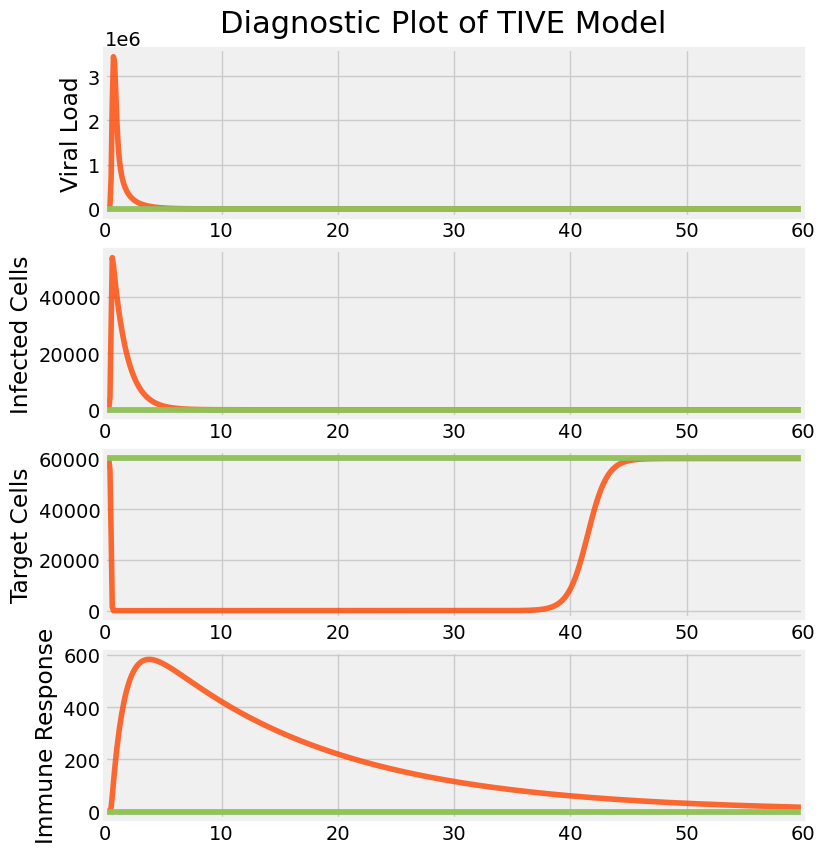

In [7]:
 make_4plots(path0_result, T=60, spd=10, colors=["orangered", "cornflowerblue", "yellowgreen"], alpha=0.8)

For the network with weight 1 on all edges, we can see infection spread to each host one by one down the path graph.

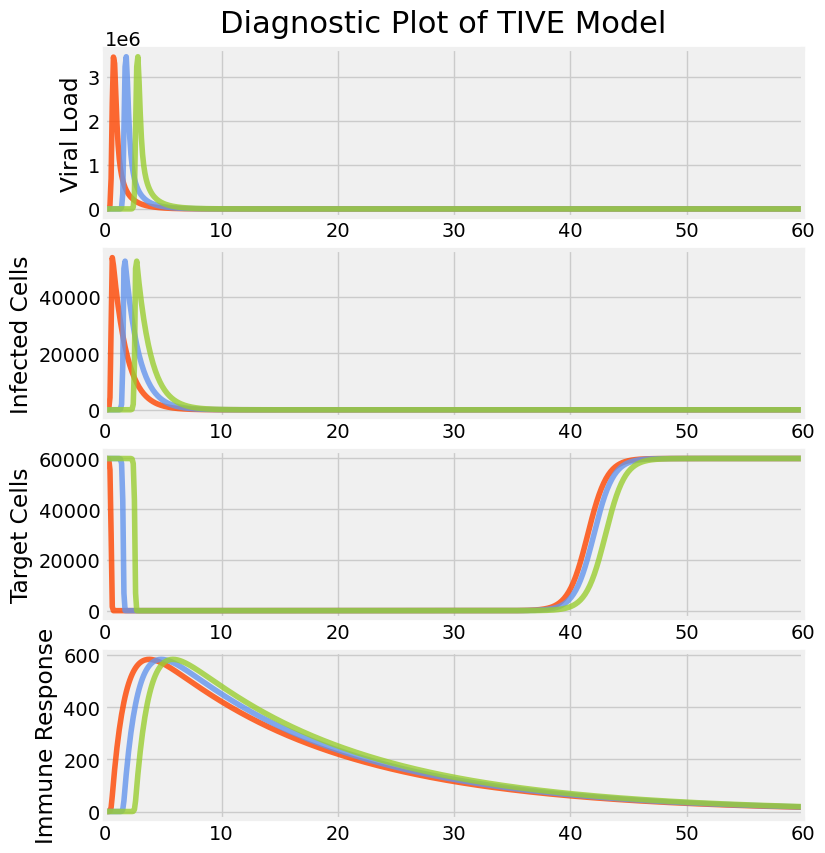

In [7]:
make_4plots(path1_result, T=60, spd=10, colors=["orangered", "cornflowerblue", "yellowgreen"], alpha=0.8)

<a id=2></a>
# Example 2) Barbell Graph

All of the following examples will repeat the procedure used in example 1, but with different network structures. In this example, we will run the simulation across a barbell graph with 7 nodes, visualized below. On one side of the barbell, all edges have weight 1, so all hosts on this side should become infected. On the other side, all edges have weight 0, so all hosts should remain uninfected.

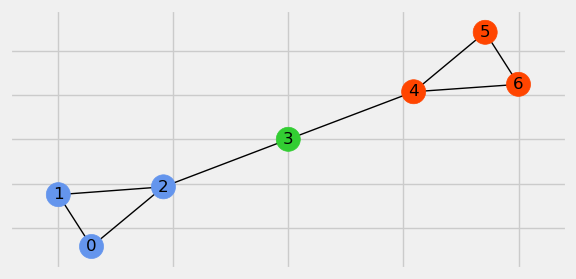

In [18]:
# Creating the barbell graph
B = nx.barbell_graph(3, 1)

# Draw the graph
plt.figure(3,figsize=(6.4,3.2))
nodeIDS = list(range(7))
# Green node initialized with infection, blue nodes should become infected and red nodes should not
barbell_colors = ["cornflowerblue"]*3 + ["limegreen"]+["orangered"]*3
nx.draw_networkx(B, nodelist=nodeIDS, node_color=barbell_colors, with_labels = True)
plt.show()

# Create and write network file and parameter data
for edge in B.edges():
    if (edge[0] or edge[1]) <= 3:
        B[edge[0]][edge[1]]['weight'] = 1
    else:
        B[edge[0]][edge[1]]['weight'] = 0
nx.write_edgelist(B, "barbell.edgelist")
# see section 1.3 for values of singlerow
barbellDf = pd.concat([singlerow]*7, ignore_index=True)
barbellDf.to_csv("barbell_params.csv", index=False)     

<a id=2.1></a>
### 2.1) Running the Simulation

In this simulation, the middle host in the barbell, host 3, is initialized with infection.

In [44]:
print_ConfigFile("barbell.txt")


NetworkFile=barbell.edgelist
NumInitialInfected=1
InitInfectedNodes=[3]

InfectionMethod=Individual
Center=1700000
Steepness=-3/1700000

Equation=tive
InfectiveIndex=2
ParameterData=barbell_params.csv
TargetInit=[60000,0,0,0]
InfectedInit=[60000,1,1/6000,0]

Duration=60
SamplesPerDay=10
InitialExposure=1e5
Seed=None


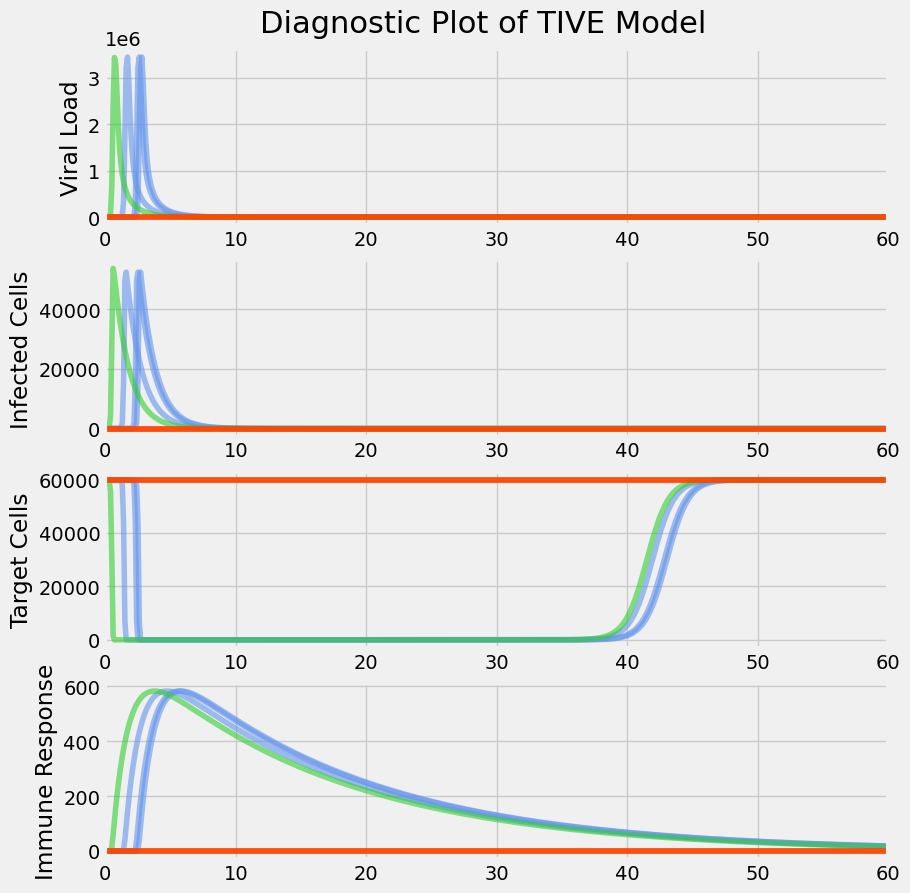

In [29]:
barbell_result = vn.simulate("barbell.txt")
make_4plots(barbell_result, T=60, spd=10, colors=barbell_colors, alpha=0.6)

<a id=2.2></a>
### 2.2) Population Viral Load
Using the visualization function written in Example 1, we can see the initially infected host only infects the side of the network with edge weight 1 and no nodes withe edge weight 0 become infected, as expected. Since multiple nodes are being infected in very quick succession, the plot from example 1 can become crowded, especially once we begin to run larger simulations. It's also easy to analyze the spread of the virus by plotting the population viral load (the sum of all of the virus present in each node at a moment in time) through time. A function to plot the population viral load is given below.

In [68]:
def getPopulationLevel(result, j, T, spd):
    """
    Helper function that creates a vector of the population level of the jth column of the state array
    result (networkx.Graph): the output graph of the simulation
    j (int): index of state array column to aggregate across
    T (int): simulation duration
    spd (int): samples per day
    
    returns: pop_tot (numpy.array([spd*T,])) population level of jth compartment through time
    """
    pop_tot = np.zeros((T*spd,))
    for i in result.nodes:
        node_lvl = result.nodes[i]["state"][:,j]
        pop_tot += node_lvl
    return pop_tot

def population_vload_plot(result, T, spd, color, alpha=1, xlim=None):
    """
    Creates a plot of the population viral load through time
    
    result (networkx.Graph): the output graph of the simulation
    j (int): index of state array column to aggregate across
    T (int): simulation duration
    spd (int): samples per day
    alpha (float): the alpha level for all curves
    xlim (int): the highest time value plotted the x axis
    
    returns: None
    """
    vload_tot = getPopulationLevel(result, 2, T, spd)
    plt.style.use('fivethirtyeight')
    time = np.linspace(0,T,T*spd)
    plt.figure(figsize=(6,3))
    plt.plot(time, vload_tot, color=color, alpha = 0.8)
    plt.ylabel("Viral Load")
    plt.xlabel("Days")
    plt.title("Population Viral Load")
    ax =  plt.gca()
    ax.set_xlim([0,xlim])
    plt.show()
    return 

Using this function, we will plot the population viral load of the barbell simulation. We can see the simultaneous infections of hosts 0 and 1 clearly by the spike in the population viral load.

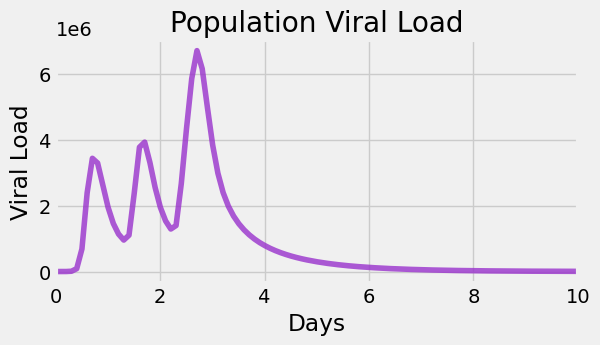

In [32]:
population_vload_plot(barbell_result, 60, 10, "darkorchid", alpha=0.8, xlim=10)

<a id=3></a>
# Example 3) Barabasi-Albert Graph

In this example, we will compare two Barabasi-Albert graphs of 15 hosts: one with a fewer number of edges attached at each step of the algorithm and one with more. The preferential attachment of edges to be added to nodes with high degree in the Barabasi-Albert algorithm is found in many natural and human phenomena. Here, these graphs represent human social networks; one with very little contact between multiple hosts and one where each host is in contact with many other hosts in the social network. To compare the effects of the network structures, the population is homogeneous (all hosts have identical sub-host parameters) and the weight on all edges in both graphs is set to 0.3. That is, all interactions between hosts along each edge can result in no more than a 10% chance of contracting the virus from an infected host at a time step in the simulation.

The configurations of for the simulation on each graph can be found in BA_low.txt and BA_high.txt

In [9]:
# Homogeneous population, all hosts in both networks will have the same sub-host diff eq parameters
BA_Df = pd.concat([singlerow]*15, ignore_index=True)
BA_Df.to_csv("barabasi_albert_params.csv", index=False) 

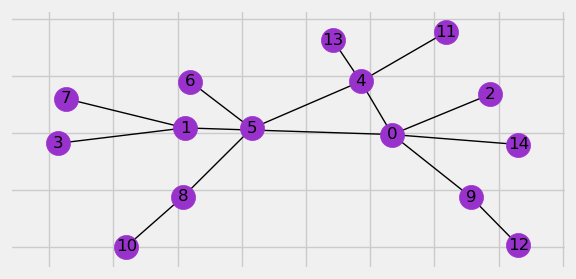

In [54]:
# low connectivity
BA_low = nx.barabasi_albert_graph(15,1, seed=3)
# Put weight of 0.1 on all edges
for edge in BA_low.edges():
    BA_low[edge[0]][edge[1]]['weight'] = 0.1
# Write the graph in edgelist format
nx.write_edgelist(BA_low, "Barabasi-AlbertLOW.edgelist")
# Draw the network
plt.figure(3,figsize=(6.4,3.2))
nx.draw_networkx(BA_low,pos=nx.spring_layout(BA_low), node_color="darkorchid", with_labels = True)
plt.show()

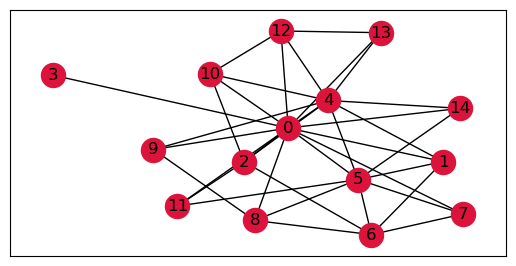

In [6]:
# high connectivity
BA_high =  nx.barabasi_albert_graph(15,3, seed=3)
# Put weight of 0.3 on all edges
for edge in BA_high.edges():
    BA_high[edge[0]][edge[1]]['weight'] = 0.1
# Write the graph in edgelist format
nx.write_edgelist(BA_high, "Barabasi-AlbertHIGH.edgelist")
# Draw the network
plt.figure(3,figsize=(6.4,3.2))
nx.draw_networkx(BA_high,pos=nx.spring_layout(BA_high), node_color = "crimson", with_labels = True)
plt.show()

<a id=3.1></a>

### 3.1) Running the Simulations

In [56]:
print_ConfigFile("BarabasiAlbert_low.txt")

NetworkFile=Barabasi-AlbertLOW.edgelist
NumInitialInfected=1
InitInfectedNodes=[5]

InfectionMethod=Individual
Center=1700000
Steepness=-3/1700000
InitialExposure=1e5

Equation=tive
InfectiveIndex=2
ParameterData=barabasi_albert_params.csv
TargetInit=[60000,0,0,0]
InfectedInit=[60000,1,1/6000,0]

Duration=100
SamplesPerDay=10


In [57]:
BA_low_result = vn.simulate("BarabasiAlbert_low.txt")

In [58]:
print_ConfigFile("BarabasiAlbert_high.txt")


NetworkFile=Barabasi-AlbertHIGH.edgelist
NumInitialInfected=1
InitInfectedNodes=[6]

InfectionMethod=Individual
Center=1700000
Steepness=-3/1700000
InitialExposure=1e5

Equation=tive
InfectiveIndex=2
ParameterData=barabasi_albert_params.csv
TargetInit=[60000,0,0,0]
InfectedInit=[60000,1,1/6000,0]

Duration=100
SamplesPerDay=10


In [59]:
BA_high_result = vn.simulate("BarabasiAlbert_low.txt")

<a id=3.2></a>
### 3.2) Comparing the Population Viral Load

To compare how the network structure affected the spread of the virus, we plot the viral loads produced from each simulation. How did the network structures impact the spread of the virus?

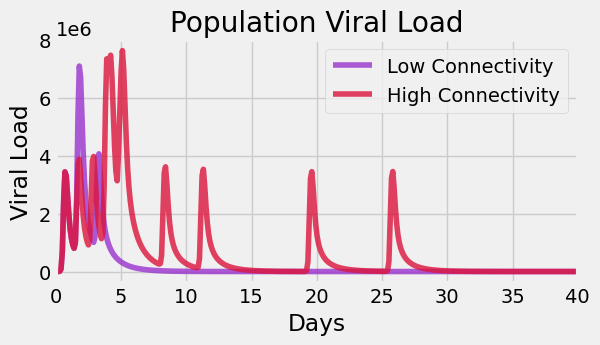

In [66]:
# Get population viral load from each simulation
BAlow_vload = getPopulationLevel(BA_low_result, 2, 100, 10)
BAhigh_vload = getPopulationLevel(BA_high_result, 2, 100, 10)
# Plot curves on the same axis
plt.style.use('fivethirtyeight')
time = np.linspace(0,100,1000)
plt.figure(figsize=(6,3))
plt.plot(time, BAlow_vload, color="darkorchid", alpha = 0.8, label="Low Connectivity")
plt.plot(time, BAhigh_vload, color="crimson", alpha = 0.8, label="High Connectivity")
plt.ylabel("Viral Load")
plt.xlabel("Days")
plt.title("Population Viral Load")
ax =  plt.gca()
ax.set_xlim([0,40])
plt.legend()
plt.show()